In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import pandas as pd


In [2]:
df = pd.read_csv("diabetes_engineered_normalized_balanced.csv")

df.head()

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,age_group,gender_Female,...,Female_Child,Female_Adult,Female_Old,Other_Child,Other_Adult,Other_Old,age_squared,bmi_category,HbA1c_above_6_5,blood_glucose_above_126
0,1.389214,0,1,former,0.326336,0.155970,1.510204,1,Old,False,...,0,0,0,0,0,0,5329.0,Overweight,0,1
1,0.810480,0,0,No Info,-1.390648,2.485395,-0.298664,1,Adult,True,...,0,1,0,0,0,0,3600.0,Underweight,1,1
2,1.611804,0,0,never,1.846798,1.180917,0.410216,1,Old,True,...,0,0,1,0,0,0,6084.0,Obese,1,1
3,0.676926,0,0,never,0.098784,0.528678,0.043554,1,Adult,False,...,0,0,0,0,0,0,3249.0,Overweight,0,1
4,1.077588,0,0,never,-0.012037,1.833156,0.532437,1,Old,True,...,0,0,1,0,0,0,4356.0,Overweight,1,1


In [3]:
diabetes_counts = df['diabetes'].value_counts()

# Calculate the percentage for each class
diabetes_percentage = (diabetes_counts / len(df)) * 100

# Display the result
print("Diabetes distribution (in percentage):")
print(diabetes_percentage)

Diabetes distribution (in percentage):
diabetes
0    87.001019
1    12.998981
Name: count, dtype: float64


In [4]:
# Features (X) and target (y)
X = df.drop(columns=['diabetes'])
y = df['diabetes']

In [5]:
from sklearn.model_selection import train_test_split

# First split into training (70%) and remaining (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Then split the remaining data into test (20%) and validation (10%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42)

# Verify the distribution in each split
print("Training set distribution:\n", y_train.value_counts(normalize=True) * 100)
print("Test set distribution:\n", y_test.value_counts(normalize=True) * 100)
print("Validation set distribution:\n", y_val.value_counts(normalize=True) * 100)


Training set distribution:
 diabetes
0    87.000386
1    12.999614
Name: proportion, dtype: float64
Test set distribution:
 diabetes
0    86.998128
1    13.001872
Name: proportion, dtype: float64
Validation set distribution:
 diabetes
0    87.00468
1    12.99532
Name: proportion, dtype: float64


In [6]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming your dataframe is `df`

# Define your features (X) and target (y)
X = df.drop(columns=['diabetes'])  # Features (excluding target 'diabetes')
y = df['diabetes']  # Target variable

# Ensure that categorical columns are of type 'category'
categorical_columns = ['smoking_history', 'gender_Female', 'gender_Male', 'gender_Other', 'age_group', 'bmi_category']
X[categorical_columns] = X[categorical_columns].astype('category')

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of categorical columns (adjust according to your dataset)
categorical_features = ['smoking_history', 'gender_Female', 'gender_Male', 'gender_Other', 'age_group', 'bmi_category']

# Initialize the CatBoost model
model = CatBoostClassifier(iterations=1000,  # Number of boosting iterations
                           learning_rate=0.1,  # Step size in each iteration
                           depth=6,  # Depth of the tree
                           cat_features=categorical_features,  # Specify categorical features
                           random_state=42,
                           verbose=200)  # Print out training progress every 200 iterations

# Train the CatBoost model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Evaluate the model on the test set
print("Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))


0:	learn: 0.5448321	total: 221ms	remaining: 3m 41s
200:	learn: 0.0929458	total: 13.2s	remaining: 52.5s
400:	learn: 0.0840150	total: 26.4s	remaining: 39.4s
600:	learn: 0.0771695	total: 39.8s	remaining: 26.4s
800:	learn: 0.0718641	total: 53.4s	remaining: 13.3s
999:	learn: 0.0672872	total: 1m 7s	remaining: 0us
Test Set Evaluation:
Accuracy: 0.9655746229849194
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     16749
           1       0.94      0.78      0.85      2481

    accuracy                           0.97     19230
   macro avg       0.96      0.89      0.92     19230
weighted avg       0.97      0.97      0.96     19230

Confusion Matrix:
 [[16634   115]
 [  547  1934]]


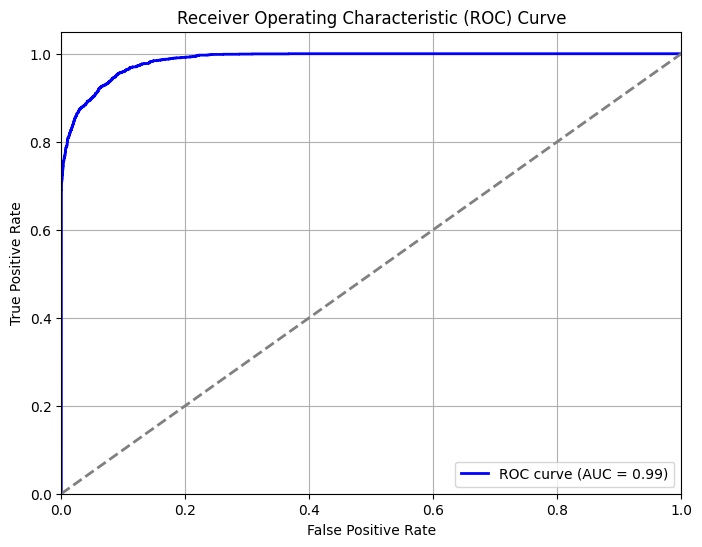

ROC AUC: 0.99


In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class (diabetic)
y_pred_prob = model.predict_proba(X_test)[:, 1]  # probabilities for class 1 (diabetic)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"ROC AUC: {roc_auc:.2f}")


In [8]:
import pickle

# Save the trained CatBoost model to a .pkl file
with open('catboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)
    
print("Model saved as 'catboost_model.pkl'")


Model saved as 'catboost_model.pkl'
